<a href="https://colab.research.google.com/github/Pavionio/Fear_and_Hate_in_Taxi/blob/main/anomaly_function.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install geopandas


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 36.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 43.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 23.7 MB/s eta 0:00:00


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.ticker import MaxNLocator
import random
import geopy.distance as gp
import plotly.express as px
import math
import geopandas as gpd
from shapely.geometry import Point
import shapely
import json
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from prophet import Prophet
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error

In [9]:

from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
!kaggle competitions list

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.9/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.9/dist-packages/kaggle/api/kaggle_api_extended.py", line 164, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [10]:
trip_duration = pd.read_csv('/content/gdrive/MyDrive/intensive/Project/nyc_taxi_trip_duration.csv')
weather = pd.read_csv('/content/gdrive/MyDrive/intensive/Project/nyc_2016_weather.csv')

In [28]:
trip_duration['distance'] = trip_duration.apply(lambda x: get_distance((x.pickup_longitude, x.pickup_latitude), (x.dropoff_longitude, x.dropoff_latitude)), axis=1)

In [11]:
def geo_anomalies(data : pd.DataFrame) -> None :
    
    
    df_for_pickup = pd.read_csv('/content/gdrive/MyDrive/intensive/Project/taxi_zones.csv')  
    df_for_dropoff = pd.read_csv('/content/gdrive/MyDrive/intensive/Project/taxi_zones.csv')  #update with the great help of Pavel Fadeev

    polygon_for_pickup = gpd.GeoDataFrame(geometry=shapely.wkt.loads(df_for_pickup.the_geom))
    polygon_for_dropoff = gpd.GeoDataFrame(geometry=shapely.wkt.loads(df_for_dropoff.the_geom))

    ls=[]

    for _,row in trip_duration.iterrows():
        ls.append(polygon_for_pickup.contains(Point(row['pickup_longitude'],row['pickup_latitude'])).any() and polygon_for_dropoff.contains(Point(row['dropoff_longitude'],row['dropoff_latitude'])).any())

    
    pickup_longitude = trip_duration[['id', 'pickup_longitude']].rename(columns={'pickup_longitude': 'longitude'})
    pickup_longitude['type'] = 'pickup'
    dropoff_longitude = trip_duration[['id', 'dropoff_longitude']].rename(columns={'dropoff_longitude': 'longitude'})
    dropoff_longitude['type'] = 'dropoff'

    longitudes = pd.concat((pickup_longitude, dropoff_longitude))

    pickup_latitude = trip_duration[['id', 'pickup_latitude']].rename(columns={'pickup_latitude': 'latitude'})
    pickup_latitude['type'] = 'pickup'
    dropoff_latitude = trip_duration[['id', 'dropoff_latitude']].rename(columns={'dropoff_latitude': 'latitude'})
    dropoff_latitude['type'] = 'dropoff'

    latitudes = pd.concat((pickup_latitude, dropoff_latitude))

    coords = pd.merge(longitudes, latitudes, on=['id', 'type'])
        

    with open('/content/gdrive/MyDrive/intensive/Project/NYC Taxi Zones.geojson') as f:
        taxi_zones = json.load(f)

    fig = px.scatter_mapbox(coords[:100000], lat='latitude', lon='longitude', hover_name='type')
    fig.update_layout(mapbox_style="open-street-map")
    fig.update_layout(mapbox_bounds={"west": -180, "east": -50, "south": 20, "north": 90})
    fig.update_traces(cluster=dict(enabled=True))
    fig.update_layout(
        mapbox = {
            'style': "open-street-map",
            'center': { 'lon': -73.9662, 'lat': 40.7834},
            'zoom': 9, 'layers': [{
                'source': taxi_zones,
                'type': "fill", 'below': "traces", 'color': "gray", 'name': 'Область работы такси',
            'opacity': 0.5}]},
        margin = {'l':0, 'r':0, 'b':0, 't':0})
    fig.show()



    data['geo_anomalies'] = ls



In [12]:
def iso_forest_trip_count_anomalies(data : pd.DataFrame) -> None :

  
    data.sort_values(by=['pickup_datetime'])
    data['ds'] = pd.to_datetime(data['pickup_datetime'].str.slice(stop=10))
    duration = data.groupby('ds',as_index=False).id.count()
    duration.rename(columns={"id": "y"},inplace=True)

    model = IsolationForest(n_estimators=150, max_samples='auto', contamination=float(0.05), max_features=1.0)

    model.fit(duration[['y']])
    
    score_anomalies =  model.decision_function(duration[['y']])
    #print('Isolation_Forest score is ', np.mean([-1*s + 0.5 for s in score_anomalies])
    
    duration['day_anomaly'] = model.predict(duration[['y']])

    an = duration.loc[duration['day_anomaly'] == -1]
    an.sort_values(by=['y'])


    plt.plot(duration.ds, duration['y'])
    plt.scatter(an.ds, an['y'], c='red', s=9)
    plt.show()

    return duration


In [31]:
def trip_parameters_anomalies(data : pd.DataFrame) -> None :

    data['avg_speed'] = data.distance /  data.trip_duration * 3600
    data['parameter_anomaly'] =  0 

    data.loc[(trip_duration.passenger_count > 8) | (trip_duration.avg_speed == 0) | (trip_duration.passenger_count == 0), 'parameter_anomaly'] = -1
    

    LOF = LocalOutlierFactor(n_neighbors=50, contamination='auto')
    x = data[['trip_duration','distance']].values
    y_pred = LOF.fit_predict(x)

    plt.figure(figsize=(12,12))


    in_mask = [True if i == 1 else False for i in y_pred]
    out_mask = [True if i == -1 else False for i in y_pred]

    plt.title("Local Outlier Factor (LOF)")

    a = plt.scatter(x[in_mask, 0], x[in_mask, 1], c = 'blue', edgecolor = 'k', s = 30)

    b = plt.scatter(x[out_mask, 0], x[out_mask, 1], c = 'red', edgecolor = 'k', s = 30)
    plt.axis('tight')
    plt.xlabel('trip_duration');
    plt.ylabel('distance');
    plt.show()

    data['knn_parameter_anomaly'] = y_pred
    
def get_distance(p1, p2):
    # p1 и p2 - это кортежи из двух элементов - координаты точек
    radius = 6373.0

    lon1 = math.radians(p1[0])
    lat1 = math.radians(p1[1])
    lon2 = math.radians(p2[0])
    lat2 = math.radians(p2[1])

    d_lon = lon2 - lon1
    d_lat = lat2 - lat1

    a = math.sin(d_lat / 2) ** 2 + math.cos(lat1) * math.cos(lat2) * math.sin(d_lon / 2) ** 2
    c = 2 * math.atan2(a ** 0.5, (1 - a) ** 0.5)

    distance = radius * c
    return distance

In [17]:
def prophet_trip_count_anomalies(data : pd.DataFrame, num_of_periods : int ) -> None :

        data.sort_values(by=['pickup_datetime'])
        data['ds'] = pd.to_datetime(data['pickup_datetime'].str.slice(stop=10))
        
        duration = data.groupby('ds',as_index=False).id.count()
        duration.rename(columns={"id": "y"},inplace=True)
        duration = duration[['ds','y']]

        m = Prophet()
        m.fit(duration)

        future = m.make_future_dataframe(periods=30)
        forecast = m.predict(future)
        m.plot(forecast)
        plt.show()

        m.plot_components(forecast)
        plt.show()


        performance = pd.merge(duration, forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds')

        performance_MAE = mean_absolute_error(performance['y'], performance['yhat'])
        print(f'\n \n The MAE for the model is {performance_MAE}')

        performance_MAPE = mean_absolute_percentage_error(performance['y'], performance['yhat'])
        print(f'The MAPE for the model is {performance_MAPE} \n \n')


        performance['anomaly'] = performance.apply(lambda rows: 1 if ((rows.y<=rows.yhat_lower)|(rows.y>=rows.yhat_upper)) else 0, axis = 1)

        anomalies = performance[performance['anomaly']==1].sort_values(by='ds')

        sns.scatterplot(x='ds', y='y', data=performance, hue='anomaly')
        sns.lineplot(x='ds', y='yhat', data=performance, color='black')

In [29]:
def Catch_Anomalies(data : pd.DataFrame, search_geo_anomalies=True, search_count_anomalies_by_iso=True, search_count_anomalies_by_prophet=True, num_of_periods=30, search_parameter_anomalies=True):

    day_duration =None

    if 'pickup_longitude' in data.columns and search_geo_anomalies: #можно проверять по всем колонкам координат
      geo_anomalies(data)

    if 'pickup_datetime' in data.columns and search_count_anomalies_by_iso:
      day_duration = iso_forest_trip_count_anomalies(data)

    if 'pickup_datetime' in data.columns and search_count_anomalies_by_prophet:
      day_duration = prophet_trip_count_anomalies(data, num_of_periods)
    
    if 'distance' and 'trip_duration' in data.columns and search_parameter_anomalies:
      trip_parameters_anomalies(data)
      

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


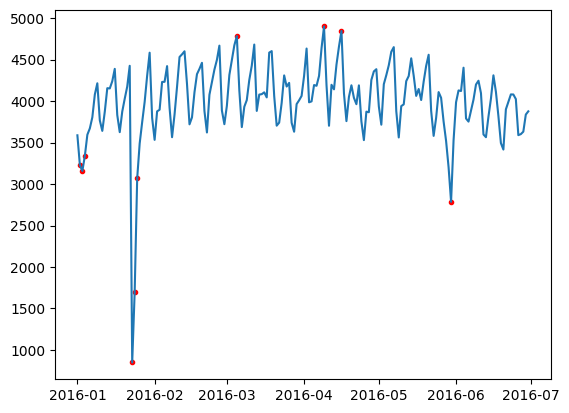

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp06o4lmy/5aws5v7y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp06o4lmy/_3vbag3h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14945', 'data', 'file=/tmp/tmpp06o4lmy/5aws5v7y.json', 'init=/tmp/tmpp06o4lmy/_3vbag3h.json', 'output', 'file=/tmp/tmpp06o4lmy/prophet_modely6ivpuo5/prophet_model-20230419204749.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:47:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:47:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


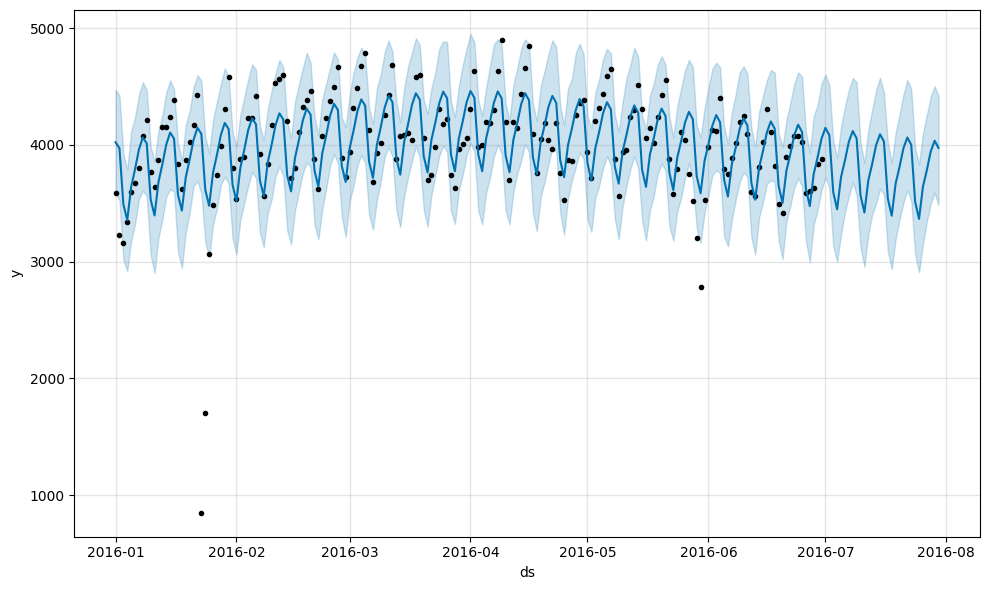

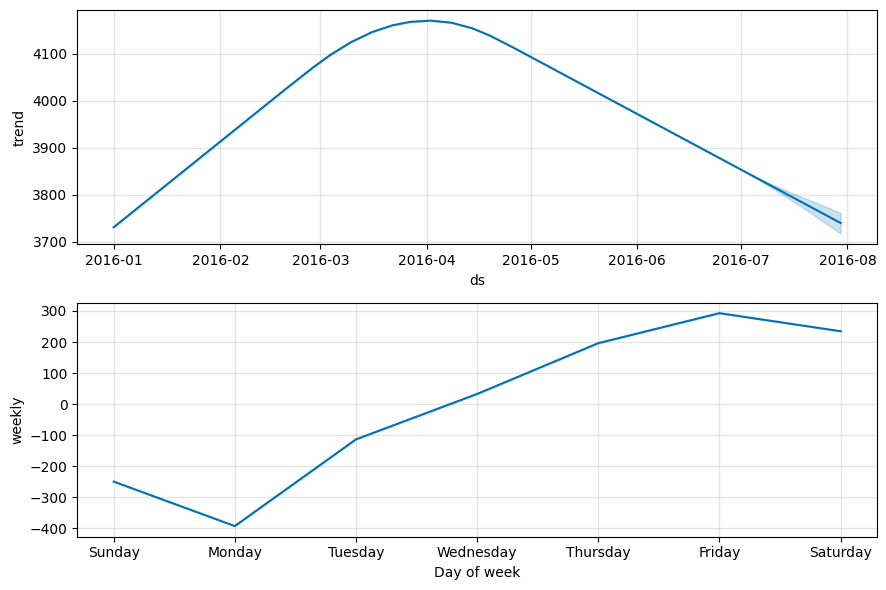


 
 The MAE for the model is 197.08738190257756
The MAPE for the model is 0.06956378969245221 
 



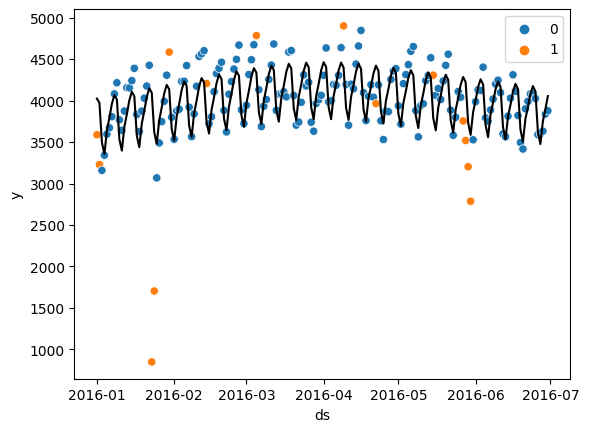

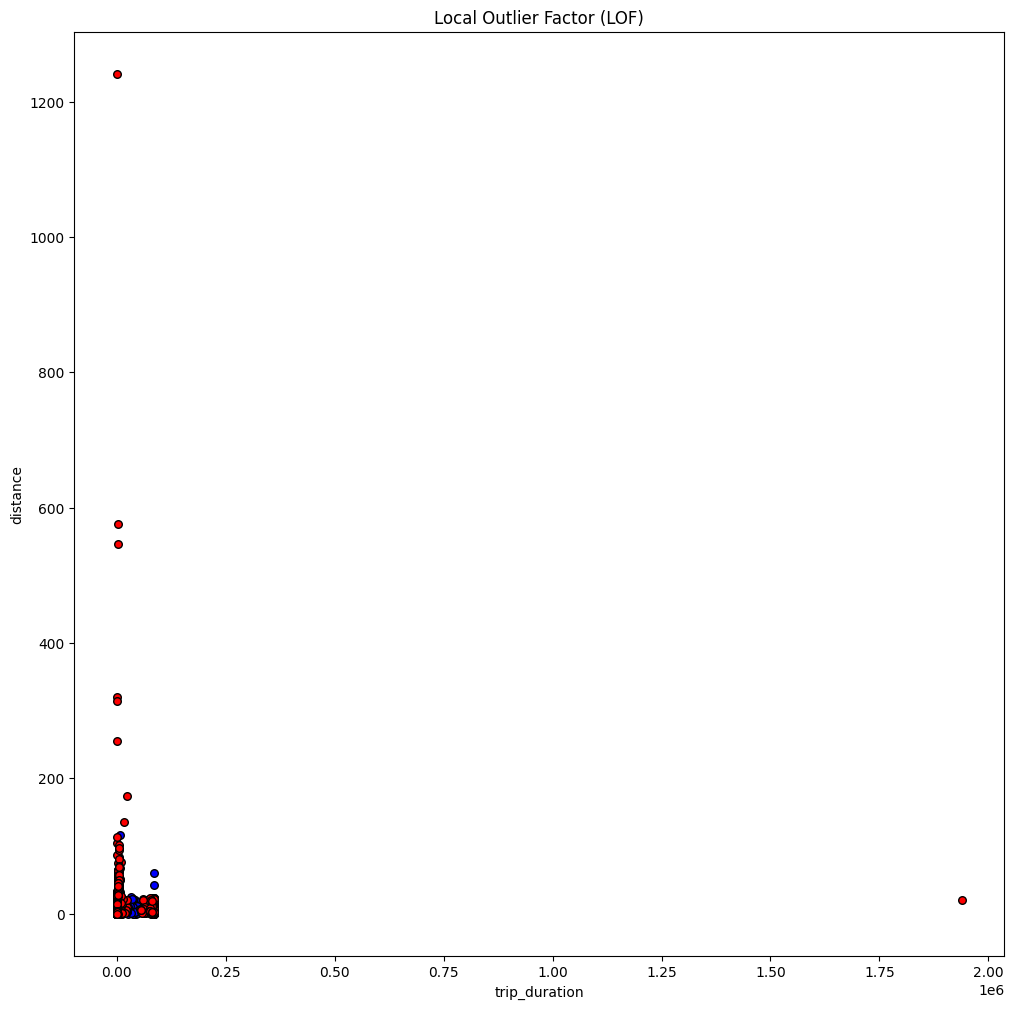

In [32]:
Catch_Anomalies(trip_duration,search_geo_anomalies=False,)

In [ ]:
def mask_f(col):
  return (col.mean() - 3*col.std()), (col.mean()  + 3*col.std())

In [ ]:
mask1 = mask_f(trip_duration.trip_duration)
mask2 = mask_f(trip_duration.distance)
td = trip_duration.trip_duration[(trip_duration.trip_duration > mask1[0]) & (trip_duration.trip_duration < mask1[1])]
ds = trip_duration.distance[(trip_duration.distance > mask2[0]) & (trip_duration.distance < mask2[1])]

In [ ]:
trip_duration.sort_values(by=['distance']).tail(20)

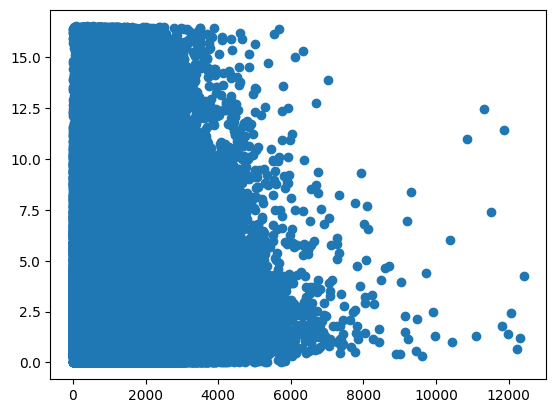

In [ ]:
plt.scatter(td[:len(ds)],ds)

In [ ]:
def mask_f(col):
  return (col.mean() - 3*col.std()), (col.mean()  + 3*col.std())


mask = mask_f(trip_duration.distance)
sns.displot(trip_duration.distance[(trip_duration.distance > mask[0]) & (trip_duration.distance < mask[1])], kind="kde")
mask = mask_f(trip_duration.trip_duration)
sns.displot(trip_duration.trip_duration[(trip_duration.distance > mask[0]) & (trip_duration.trip_duration < mask[1])], kind="kde")
mask = mask_f(trip_duration.avg_speed)
sns.displot(trip_duration.avg_speed[(trip_duration.avg_speed > mask[0]) & (trip_duration.avg_speed < mask[1])], kind="kde")